In [1]:
import requests
import json
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pynvml import *
import psutil
import os

C:\Users\HP\AppData\Local\Temp\ipykernel_3940\2238081627.py:16: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import *


In [2]:
try:
    df = pd.read_csv("../../../test_llm.csv")
except FileNotFoundError:
    print("Error: File 'test_llm.csv' not found.")
    print("Pastikan file tersebut berada di direktori yang sama dengan script ini.")
    exit()

In [3]:
test_df = df.copy()
test_df['label_score'] = test_df['Emotion']

In [4]:
import os
import time
import json
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from google import genai
from google.genai import types
from google.genai.errors import APIError
import requests # Masih diperlukan untuk psutil

# Muat Kunci API dari file .env
# Pastikan Anda memiliki file .env dengan baris: GEMINI_API_KEY="YOUR_API_KEY"
# Cari file .env dari direktori saat ini hingga ke atas
dotenv_path = find_dotenv(usecwd=True, raise_error_if_not_found=False)

if dotenv_path:
    load_dotenv(dotenv_path=dotenv_path)
else:
    print("⚠️ File .env tidak ditemukan di direktori proyek atau direktori induk.")
    # Script masih bisa berjalan jika API Key disetel sebagai Environment Variable sistem

# =================================================================
# === KONFIGURASI GEMINI API ===
# =================================================================
try:
    # Inisialisasi Klien Gemini
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    
    # Model yang diminta
    model_name = "gemini-2.5-flash"
    
except Exception as e:
    print(f"❌ Gagal menginisialisasi Gemini Client. Pastikan GEMINI_API_KEY disetel: {e}")
    # Keluar dari script jika kunci tidak ada
    client = None
    exit()

# =================================================================
# === GPU / RAM Monitor (Disederhanakan untuk RAM Lokal) ===
# VRAM monitoring dihapus karena model berjalan di cloud
# =================================================================
try:
    import psutil
    def get_ram_usage_gb():
        return psutil.virtual_memory().used / (1024 ** 3)
except ImportError:
    def get_ram_usage_gb():
        return 0.0 # Fallback jika psutil tidak terinstal

def get_vram_usage_gb():
    return 0.0 # Selalu 0.0 karena inferensi di cloud

# =================================================================
# === INISIALISASI VARIABEL ===
# =================================================================
emotion_labels = ["Anger", "Fear", "Happy", "Love", "Sadness"]
predictions = []
start_time = time.time()
PENDING_TIMEOUT = 10

# =================================================================
# === LOOP INFERENSI ===
# =================================================================

print(f"🚀 Memulai inferensi menggunakan model: {model_name}...")
print("-" * 50)

for i, row in test_df.iterrows():
    teks = row["Customer Review"]

    system_prompt = """
    Anda adalah asisten AI yang ahli dalam analisis emosi pada teks Bahasa Indonesia. 
    Tugas Anda adalah mengklasifikasikan teks pengguna ke dalam salah satu dari 
    5 kelas emosi berikut: Anger, Fear, Happy, Love, dan Sadness.

    Gunakan panduan karakteristik berikut:

    1. ANGER
    - Mengandung kata kasar atau makian.
    - Menunjukkan kemarahan, kekesalan, atau kebencian.
    - Keluhan atau ketidaksukaan terhadap produk/layanan/pengiriman.
    - Menggunakan huruf kapital berlebihan atau tanda baca marah (“!!!”, “???”).
    - Ekspresi jengkel, sebel, atau benci.

    2. FEAR
    - Kalimat peringatan atau rasa takut.
    - Kekhawatiran terhadap produk atau penjual.
    - Keraguan, ketidakpastian, atau menanyakan hal yang membuat cemas.
    - Ekspresi hati-hati, waspada, curiga, atau ragu terhadap keamanan.

    3. HAPPY
    - Mengandung pujian.
    - Kepuasan terhadap produk/penjual.
    - Ekspresi senang, gembira, bahagia, atau puas.
    - Bangga dan memberikan penilaian positif terhadap kualitas produk/penjual.

    4. LOVE
    - Ekspresi perasaan sayang, suka, atau rasa cinta.
    - Sangat puas terhadap produk.
    - Mengandung ungkapan hiperbola/“berlebihan” untuk menyanjung.
    - Mengandung pujian kuat atau kekaguman mendalam.
    - Ekspresi bangga atau sangat menyukai produk/penjual.

    5. SADNESS
    - Menyatakan kekecewaan terhadap produk.
    - Penyesalan, sedih, atau tidak puas.
    - Ekspresi kecewa, menyesal, atau merasa dirugikan.

    Keluaran Anda HARUS berupa JSON dengan format:
    {"emosi": "<Anger/Fear/Happy/Love/Sadness>"}
    """

    few_shot_examples = """
    Berikut adalah 5 contoh kasus klasifikasi emosi (5-SHOTS) beserta output JSON yang diharapkan. Model HARUS mengikuti format ini:

    --- Contoh 1 (Fear) ---
    Teks ulasan: "Barang tidak sesuai dengan yg di iklankan seperti nya bekas"
    Output: {"emosi": "Fear"}
    
    --- Contoh 2 (Happy) ---
    Teks ulasan: "pengiriman cepat, packing rapi, kualitas mantap"
    Output: {"emosi": "Happy"}

    --- Contoh 3 (Anger) ---
    Teks ulasan: "Barang Rusak , Ga Guna Sama Sekali ... Parah"
    Output: {"emosi": "Anger"}

    --- Contoh 4 (Love) ---
    Teks ulasan: "Bagus banget keyboardnya. Packing sangat aman karena double kardus. Warna juga keren."
    Output: {"emosi": "Love"}

    --- Contoh 5 (Sadness) ---
    Teks ulasan: "Kecewa parah nggk berkah jualan gitu"
    Output: {"emosi": "Sadness"}

    Klasifikasikan teks ulasan baru di bawah berdasarkan konteks 5 contoh di atas.
    """

    # === USER PROMPT (Ditingkatkan dengan instruksi yang lebih tegas) ===
    user_prompt = f"""
    {few_shot_examples}
    
    Teks ulasan berikut: 
    "{teks}"

    Klasifikasikan teks tersebut ke dalam salah satu emosi berikut:
    {', '.join(emotion_labels)}.
    """
    
    messages = [
        types.Content(role="user", parts=[types.Part(text=user_prompt)]), # Gunakan constructor dengan keyword 'text'
    ]
    
    # Set System Instruction secara eksplisit untuk Gemini
    config = types.GenerateContentConfig(
        system_instruction=system_prompt,
        response_mime_type="application/json", # Instruksi output JSON
        response_schema={"type": "object", "properties": {"emosi": {"type": "string"}}}
    )

    t0 = time.time()

    try:
        # === REQUEST GEMINI API ===
        response = client.models.generate_content(
            model=model_name,
            contents=messages,
            config=config,
        )

        # --- Lacak Token ---
        if response.usage_metadata:
            input_tokens = response.usage_metadata.prompt_token_count
            output_tokens = response.usage_metadata.candidates_token_count
        # -------------------
        
        assistant_response_string = response.text.strip()
        
        if not assistant_response_string:
            print(f"[{i}] ⚠️ Respons kosong dari model untuk: {teks[:60]}...")
            continue
            
        try:
            # Karena kita meminta JSON, kita bisa langsung memuatnya.
            hasil = json.loads(assistant_response_string)
        except json.JSONDecodeError:
            print(f"[{i}] ⚠️ Gagal parse JSON dari respons teks mentah: {assistant_response_string}")
            continue

        emosi_pred = hasil.get("emosi", "").capitalize().strip()

        if emosi_pred not in emotion_labels:
            print(f"[{i}] 🛑 Emosi tidak valid ({emosi_pred}). Fallback ke Neutral.")
            emosi_pred = "Neutral" 

        latency = time.time() - t0
        ram_usage = get_ram_usage_gb()
        vram_usage = get_vram_usage_gb()

        predictions.append({
            "text": teks,
            "actual": row["Emotion"],
            "predicted": emosi_pred,
            "latency_sec": latency,
            "ram_gb": ram_usage,
            "vram_gb": vram_usage,
            "prompt_tokens": input_tokens,
            "completion_tokens": output_tokens
        })

        print(f"[{i}] {teks[:60]}... → Pred: **{emosi_pred}** "
              f"({latency:.2f}s) | Token: In={input_tokens}, Out={output_tokens} | RAM: {ram_usage:.2f} GB")
        
        # === TIMEOUT PENDING 10 DETIK ===
        print(f"[{i}] 💤 Menunggu {PENDING_TIMEOUT} detik...")
        time.sleep(PENDING_TIMEOUT)
        # ===============================
        
        
    except APIError as e:
        print(f"[{i}] ❌ Kesalahan API Gemini: {e}")
        # Lanjutkan ke iterasi berikutnya atau hentikan jika error fatal
        continue 
    except Exception as e:
        print(f"[{i}] ⚠️ Error tak terduga memproses teks: {teks[:60]} | Detail: {e}")
        continue

# =================================================================
# === RINGKASAN STATISTIK (Diperbarui untuk Token) ===
# =================================================================
end_time = time.time()
total_time = end_time - start_time

if predictions:
    latencies = [p["latency_sec"] for p in predictions]
    # Abaikan latency pertama (warm-up)
    latencies_no_first = latencies[1:] if len(latencies) > 1 else latencies
    
    avg_latency = sum(latencies_no_first) / len(latencies_no_first) if latencies_no_first else 0
    total_time_no_first = sum(latencies_no_first)
    throughput = (len(latencies_no_first) / total_time_no_first) * 60 if total_time_no_first > 0 else 0

    avg_ram = sum(p["ram_gb"] for p in predictions) / len(predictions)
    avg_vram = sum(p["vram_gb"] for p in predictions) / len(predictions)
    
    avg_prompt_tokens = sum(p["prompt_tokens"] for p in predictions) / len(predictions)
    avg_completion_tokens = sum(p["completion_tokens"] for p in predictions) / len(predictions)


    print("\n" + "=" * 50)
    print("=== 📊 Ringkasan Evaluasi ===")
    print("=" * 50)
    print(f"Total sampel diproses: {len(predictions)} dari {len(test_df)}")
    print(f"Total waktu uji coba : {total_time:.2f} detik")
    print(f"Rata-rata latency: **{avg_latency:.2f} detik/sampel** (tanpa warm-up)")
    print(f"Throughput: **{throughput:.2f} sampel/menit** (tanpa warm-up)")
    print("-" * 50)
    print(f"Rata-rata Prompt Tokens: {avg_prompt_tokens:.0f}")
    print(f"Rata-rata Completion Tokens: {avg_completion_tokens:.0f}")
    print("-" * 50)
    print(f"Rata-rata RAM: {avg_ram:.2f} GB")
    print(f"Rata-rata VRAM: {avg_vram:.2f} GB")
    print("=" * 50)

    # === Simpan ke CSV ===
    results_df = pd.DataFrame(predictions)
    results_df.to_csv("results_metrics_emotion.csv", index=False)
    print("\n✅ Hasil disimpan ke: **results_metrics_emotion.csv**")
else:
    print("\n❌ Tidak ada prediksi yang berhasil disimpan. Cek koneksi Anda ke API dan Kunci API.")

🚀 Memulai inferensi menggunakan model: gemini-2.5-flash...
--------------------------------------------------
[0] buahnya bagus... kurirnya ok sellernya juga ok... → Pred: **Happy** (2.77s) | Token: In=784, Out=7 | RAM: 13.44 GB
[0] 💤 Menunggu 10 detik...
[1] Ada sedikit cacat, selainnya oke... → Pred: **Sadness** (6.74s) | Token: In=780, Out=8 | RAM: 13.42 GB
[1] 💤 Menunggu 10 detik...
[2] Jadi semangat mancing.... → Pred: **Happy** (2.43s) | Token: In=776, Out=7 | RAM: 13.36 GB
[2] 💤 Menunggu 10 detik...
[3] Cepat tiba n kemasan bagus. barangnya juga bagus... → Pred: **Happy** (2.90s) | Token: In=784, Out=7 | RAM: 13.49 GB
[3] 💤 Menunggu 10 detik...
[4] Produk sesuai deskripsi??. Variasi produk beragam. Berfungsi... → Pred: **Fear** (5.87s) | Token: In=788, Out=7 | RAM: 13.39 GB
[4] 💤 Menunggu 10 detik...
[5] pelayanan memuaskan dan barang sesuai ??... → Pred: **Happy** (4.23s) | Token: In=781, Out=7 | RAM: 13.30 GB
[5] 💤 Menunggu 10 detik...
[6] ❌ Kesalahan API Gemini: 503 UNAVAILAB

In [17]:
import os
import json
import time
from dotenv import load_dotenv, find_dotenv
from google import genai
from google.genai import types
from google.genai.errors import APIError

# ==========================================================
# Load API Key
# ==========================================================
dotenv_path = find_dotenv(usecwd=True, raise_error_if_not_found=False)
if dotenv_path:
    load_dotenv(dotenv_path=dotenv_path)

client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
model_name = "gemini-2.5-flash"

emotion_labels = ["Anger", "Fear", "Happy", "Love", "Sadness"]

# ==========================================================
# MASUKKAN TEKS YANG INGIN DIPREDIKSI
# ==========================================================
sample_text = "baunya pasaran, prtama kali pakai semua orang sekitar gue sakit kepala.. jangan trlalu expektasi tinggi... rugi kalian harga segitu.."
# ujung buku rusak.. padahal sudah mahal beli buku import
# baunya pasaran, prtama kali pakai semua orang sekitar gue sakit kepala.. jangan trlalu expektasi tinggi... rugi kalian harga segitu..

# ==========================================================
# Prompt System
# ==========================================================
system_prompt = """
    Anda adalah asisten AI yang ahli dalam analisis emosi pada teks Bahasa Indonesia. 
    Tugas Anda adalah mengklasifikasikan teks pengguna ke dalam salah satu dari 
    5 kelas emosi berikut: Anger, Fear, Happy, Love, dan Sadness.

    Gunakan panduan karakteristik berikut:

    1. ANGER
    - Mengandung kata kasar atau makian.
    - Menunjukkan kemarahan, kekesalan, atau kebencian.
    - Keluhan atau ketidaksukaan terhadap produk/layanan/pengiriman.
    - Menggunakan huruf kapital berlebihan atau tanda baca marah (“!!!”, “???”).
    - Ekspresi jengkel, sebel, atau benci.

    2. FEAR
    - Kalimat peringatan atau rasa takut.
    - Kekhawatiran terhadap produk atau penjual.
    - Keraguan, ketidakpastian, atau menanyakan hal yang membuat cemas.
    - Ekspresi hati-hati, waspada, curiga, atau ragu terhadap keamanan.

    3. HAPPY
    - Mengandung pujian.
    - Kepuasan terhadap produk/penjual.
    - Ekspresi senang, gembira, bahagia, atau puas.
    - Bangga dan memberikan penilaian positif terhadap kualitas produk/penjual.

    4. LOVE
    - Ekspresi perasaan sayang, suka, atau rasa cinta.
    - Sangat puas terhadap produk.
    - Mengandung ungkapan hiperbola/“berlebihan” untuk menyanjung.
    - Mengandung pujian kuat atau kekaguman mendalam.
    - Ekspresi bangga atau sangat menyukai produk/penjual.

    5. SADNESS
    - Menyatakan kekecewaan terhadap produk.
    - Penyesalan, sedih, atau tidak puas.
    - Ekspresi kecewa, menyesal, atau merasa dirugikan.

    Keluaran Anda HARUS berupa JSON dengan format:
    {"emosi": "<Anger/Fear/Happy/Love/Sadness>"}
    """

# ==========================================================
# Few-shots (disingkat dari script Anda)
# ==========================================================
few_shot_examples = """
    Berikut adalah 5 contoh kasus klasifikasi emosi (5-SHOTS) beserta output JSON yang diharapkan. Model HARUS mengikuti format ini:

    --- Contoh 1 (Fear) ---
    Teks ulasan: "Barang tidak sesuai dengan yg di iklankan seperti nya bekas"
    Output: {"emosi": "Fear"}
    
    --- Contoh 2 (Happy) ---
    Teks ulasan: "pengiriman cepat, packing rapi, kualitas mantap"
    Output: {"emosi": "Happy"}

    --- Contoh 3 (Anger) ---
    Teks ulasan: "Barang Rusak , Ga Guna Sama Sekali ... Parah"
    Output: {"emosi": "Anger"}

    --- Contoh 4 (Love) ---
    Teks ulasan: "Bagus banget keyboardnya. Packing sangat aman karena double kardus. Warna juga keren."
    Output: {"emosi": "Love"}

    --- Contoh 5 (Sadness) ---
    Teks ulasan: "Kecewa parah nggk berkah jualan gitu"
    Output: {"emosi": "Sadness"}

    Klasifikasikan teks ulasan baru di bawah berdasarkan konteks 5 contoh di atas.
    """

# ==========================================================
# User Prompt
# ==========================================================
user_prompt = f"""
    {few_shot_examples}
    
    Teks ulasan berikut: 
    "{sample_text}"

    Klasifikasikan teks tersebut ke dalam salah satu emosi berikut:
    {', '.join(emotion_labels)}.
    """

messages = [
    types.Content(role="user", parts=[types.Part(text=user_prompt)])
]

config = types.GenerateContentConfig(
    system_instruction=system_prompt,
    response_mime_type="application/json",
    response_schema={
        "type": "object",
        "properties": {
            "emosi": {"type": "string"}
        }
    }
)

# ==========================================================
# PREDIKSI
# ==========================================================
try:
    t0 = time.time()
    response = client.models.generate_content(
        model=model_name,
        contents=messages,
        config=config
    )
    latency = time.time() - t0

    json_raw = response.text.strip()
    result = json.loads(json_raw)

    predicted = result.get("emosi", "").capitalize()
    if predicted not in emotion_labels:
        predicted = "Neutral"

    print("\n==============================")
    print("       HASIL PREDIKSI")
    print("==============================")
    print("Teks:", sample_text)
    print("Prediksi Emosi:", predicted)
    print(f"Latency: {latency:.2f} detik")

    if response.usage_metadata:
        print(f"Prompt Tokens: {response.usage_metadata.prompt_token_count}")
        print(f"Output Tokens: {response.usage_metadata.candidates_token_count}")

    print("==============================\n")

except APIError as e:
    print("❌ API Error:", e)
except Exception as e:
    print("❌ Unexpected Error:", e)



       HASIL PREDIKSI
Teks: baunya pasaran, prtama kali pakai semua orang sekitar gue sakit kepala.. jangan trlalu expektasi tinggi... rugi kalian harga segitu..
Prediksi Emosi: Sadness
Latency: 5.55 detik
Prompt Tokens: 803
Output Tokens: 8



In [18]:
results_df = pd.read_csv('results_metrics_emotion.csv')

In [1]:
import pandas as pd

# Load data
df = pd.read_csv("results_metrics_emotion.csv")

# Ambil latency per sampel (detik)
latencies = df["latency_sec"].values

# Jumlah sampel
N = len(latencies)

# ------------------------
# LATENCY (Persamaan 5)
# ------------------------
avg_latency = latencies.sum() / N  # detik per sampel

# ------------------------
# THROUGHPUT (Persamaan 6)
# ------------------------
T_seconds = latencies.sum()        # total waktu pemrosesan (detik)
throughput_per_minute = (N / T_seconds) * 60

print(f"Jumlah sampel (N): {N}")
print(f"Rata-rata latency (s/sample): {avg_latency:.2f}")
print(f"Throughput (sample/minute): {throughput_per_minute:.2f}")


Jumlah sampel (N): 225
Rata-rata latency (s/sample): 4.59
Throughput (sample/minute): 13.07


In [19]:
y_true = results_df["actual"]
y_pred = results_df["predicted"]

In [20]:
report = classification_report(y_true, y_pred, digits=2, zero_division=0)
print("\n=== CLASSIFICATION REPORT ===")
print(report)


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Anger       0.60      0.73      0.66        45
        Fear       0.40      0.04      0.08        45
       Happy       0.73      0.84      0.78        45
        Love       0.88      0.67      0.76        45
     Sadness       0.47      0.82      0.60        45

    accuracy                           0.62       225
   macro avg       0.62      0.62      0.58       225
weighted avg       0.62      0.62      0.58       225



In [21]:
accuracy = accuracy_score(y_true, y_pred)
precision_avg = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_avg = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_avg = f1_score(y_true, y_pred, average="macro", zero_division=0)

In [22]:
print(f"Precision avg : {precision_avg:.2f}")
print(f"Recall avg : {recall_avg:.2f}")
print(f"F1 avg : {f1_avg:.2f}")
print(f"Akurasi : {accuracy:.2f}")

Precision avg : 0.62
Recall avg : 0.62
F1 avg : 0.58
Akurasi : 0.62


✅ Confusion matrix disimpan di 'confusion_matrix_emotion_llm.png'


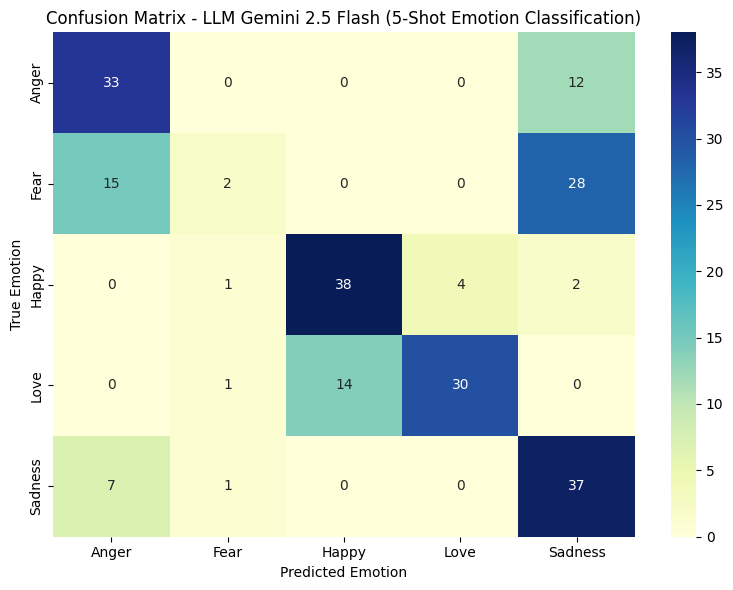

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Buat confusion matrix ===
cm = confusion_matrix(y_true, y_pred, labels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])

# === Plot heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'],
            yticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])

plt.title("Confusion Matrix - LLM Gemini 2.5 Flash (5-Shot Emotion Classification)")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.tight_layout()
plt.savefig("confusion_matrix_emotion_llm.png", dpi=300)
print("✅ Confusion matrix disimpan di 'confusion_matrix_emotion_llm.png'")
plt.show()